# Introduction

Healthcare inequity is a global challenge.

Addressing this challenge has an extensive positive impact on women’s health, which is key for societies and economies to thrive. 

This datathon was designed to help discover whether disparate treatments exist and to understand the drivers of those biases, such as demographic and societal factors.


In [2]:
# Import Libraries

from sklearn.pipeline import Pipeline

import numpy as np # linear algebra
import pandas as pd # for data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # for data visualization
import matplotlib.pyplot as plt # for data visulaization
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
import catboost
import xgboost
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

# 모든 컬럼의 문자열 길이를 제한 없이 출력
pd.set_option('display.max_colwidth', None)


In [3]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Load datasets

The dataset for this challenge contained health related information of patients who were diagnosed with metastatic triple negative breast cancers in the US. 

The data set was also enriched with the US Zip Codes Database which were built from the ground up using authoritative sources including the U.S. Postal Service™, U.S. Census Bureau, National Weather Service, American Community Survey, and the IRS, to obtain additional social economic information based on the locations of the patients.


The dataset was then further enriched, also using zip code level, with toxicology data from NASA/Columbia University, to explore the relations between health outcomes and toxic air conditions.


In [5]:
# Load Competiton Datasets and drop breast_cancer_diagnosis_code
df = pd.read_csv("./dataset/training.csv")
tdf = pd.read_csv("./dataset/test.csv")
ss = pd.read_csv("./dataset/sample_submission.csv")

In [6]:
df[df['bmi']>=50]

,patient_id,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,...,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
2371,306828,NaN,COMMERCIAL,OH,440,35,F,75.0,C50311,Malig neoplm of lower-inner quadrant of right female breast,...,12.303509,10.991228,1.331579,26.750909,7.594737,7.914035,39.893560,7.673232,15.246437,1
5076,596747,Other,NaN,CA,950,20,F,85.0,C50911,Malignant neoplasm of unsp site of right female breast,...,9.579487,7.113158,6.102632,29.178947,5.389744,4.146154,35.556054,5.752438,11.100666,1


In [7]:
df['bmi'].isnull().sum()

np.int64(8965)

In [8]:
df['patient_zip3']

0        924
1        928
2        760
3        926
4        836
        ... 
12901    436
12902    945
12903    926
12904    112
12905    336
Name: patient_zip3, Length: 12906, dtype: int64

In [9]:
import pandas as pd

# 결측치가 하나라도 존재하는 컬럼만 출력
missing_cols = df.columns[df.isnull().any()]
print(missing_cols.tolist())


['patient_race', 'payer_type', 'patient_state', 'bmi', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type', 'Region', 'Division', 'population', 'density', 'age_median', 'age_under_10', 'age_10_to_19', 'age_20s', 'age_30s', 'age_40s', 'age_50s', 'age_60s', 'age_70s', 'age_over_80', 'male', 'female', 'married', 'divorced', 'never_married', 'widowed', 'family_size', 'family_dual_income', 'income_household_median', 'income_household_under_5', 'income_household_5_to_10', 'income_household_10_to_15', 'income_household_15_to_20', 'income_household_20_to_25', 'income_household_25_to_35', 'income_household_35_to_50', 'income_household_50_to_75', 'income_household_75_to_100', 'income_household_100_to_150', 'income_household_150_over', 'income_household_six_figure', 'income_individual_median', 'home_ownership', 'housing_units', 'home_value', 'rent_median', 'rent_burden', 'education_less_highschool', 'education_highschool', 'education_some_college', 'education_bachelors', '

<Axes: >

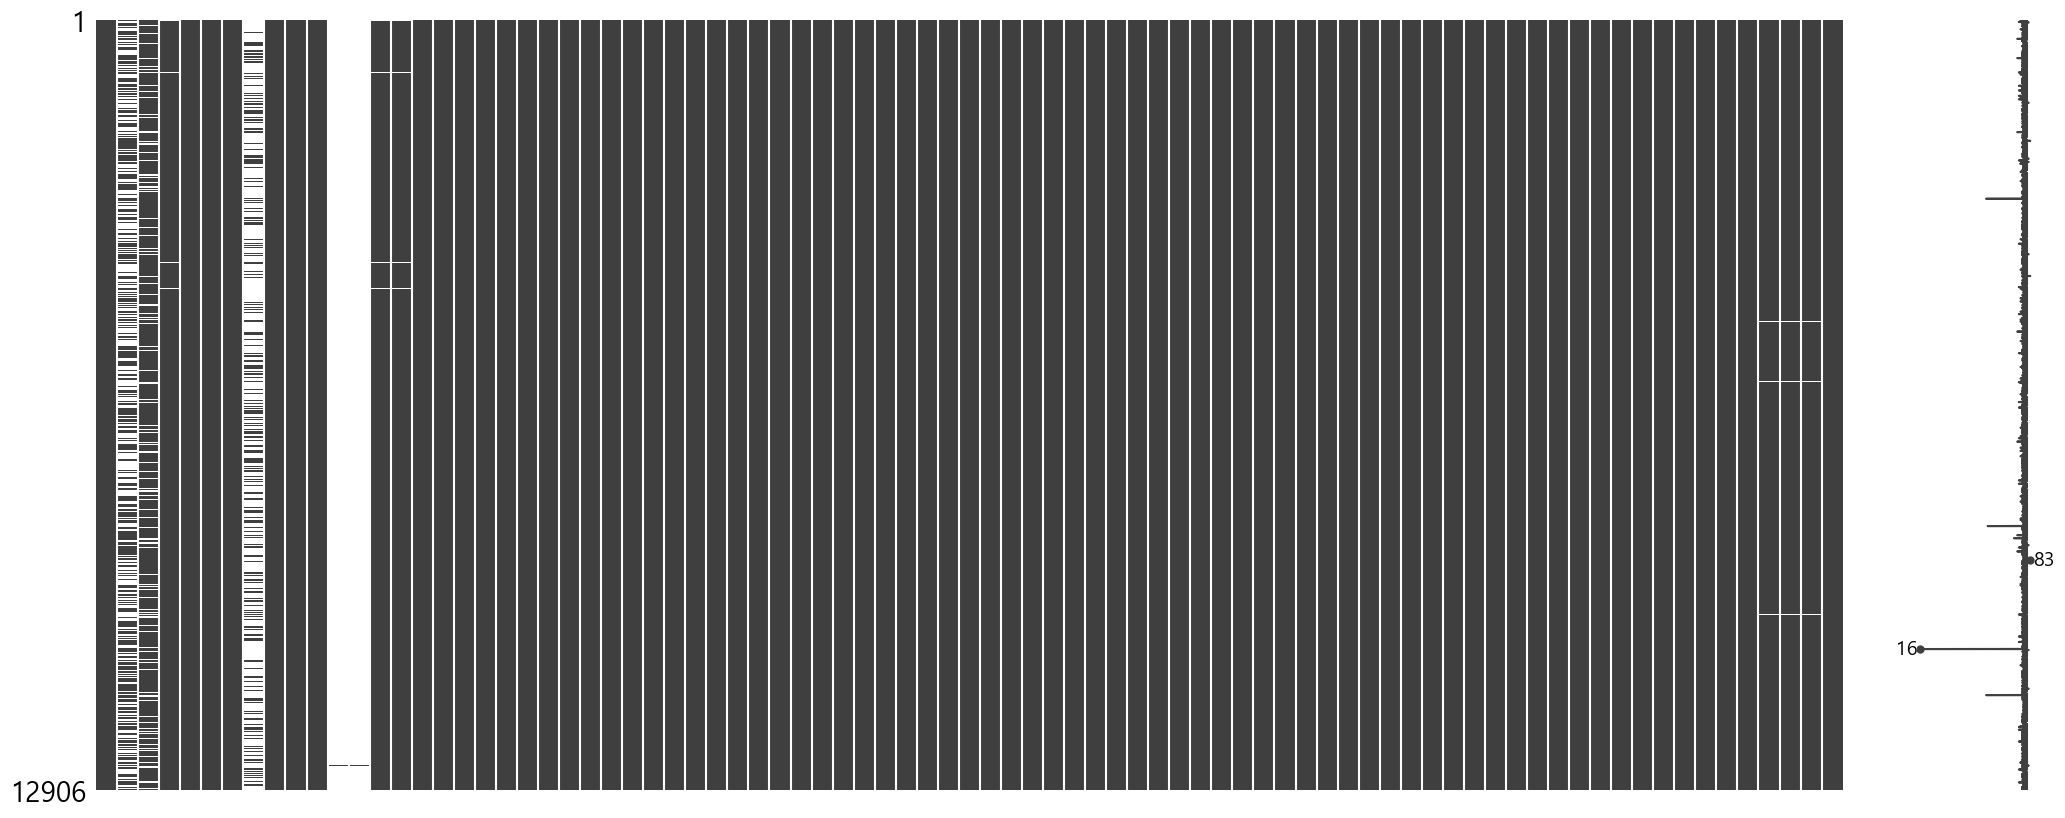

In [10]:
!pip install missingno
import missingno as msno

msno.matrix(df)


In [11]:
# 컬럼별 결측치 개수 확인
missing_info = df.isnull().sum()
# 결측치가 1개 이상인 컬럼만 필터링
missing_info = missing_info[missing_info > 0]
print(missing_info)


patient_race                         6385
payer_type                           1803
patient_state                          51
bmi                                  8965
metastatic_first_novel_treatment    12882
                                    ...  
health_uninsured                        1
veteran                                 1
Ozone                                  29
PM25                                   29
N02                                    29
Length: 75, dtype: int64


In [12]:
df.describe()

,patient_id,patient_zip3,patient_age,bmi,population,density,age_median,age_under_10,age_10_to_19,age_20s,...,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
count,12906.000000,12906.000000,12906.000000,3941.000000,12905.000000,12905.000000,12905.000000,12905.000000,12905.000000,12905.000000,...,12905.000000,12902.000000,12902.000000,12905.000000,12905.000000,12905.000000,12877.000000,12877.000000,12877.000000,12906.000000
mean,547381.196033,573.754300,59.183326,28.984539,20744.441237,1581.950419,40.502259,11.122784,12.945265,13.290376,...,13.335299,13.406950,4.474956,27.978387,8.575284,7.083376,39.822352,7.475221,16.098988,0.624516
std,260404.959974,275.447534,13.335216,5.696906,13886.903756,2966.305306,4.036963,1.512376,1.923974,3.354103,...,3.690949,5.222495,4.837085,5.083939,4.203482,3.109022,3.559492,1.516499,5.842501,0.484266
min,100063.000000,101.000000,18.000000,14.000000,635.545455,0.916667,20.600000,0.000000,6.314286,5.925000,...,4.600000,3.433333,0.000000,12.460784,2.440000,1.200000,30.939316,2.636008,2.760371,0.000000
25%,321517.000000,331.000000,50.000000,24.660000,9463.896552,171.857143,37.129825,10.160000,11.741176,11.013415,...,10.270492,9.663333,0.994444,24.933333,5.618750,4.929688,37.698880,6.651215,11.280694,0.000000
50%,543522.000000,554.000000,59.000000,28.190000,19154.190480,700.337500,40.639344,11.039216,12.923944,12.538095,...,12.884000,12.177778,2.747222,27.788235,7.465714,6.847059,39.108249,7.686577,15.589148,1.000000
75%,772671.750000,846.000000,67.000000,32.920000,30021.278690,1666.515385,42.934783,12.190000,14.019767,14.971053,...,15.555405,16.635556,5.976000,30.709375,10.617442,8.620000,41.136513,8.276922,20.801880,1.000000
max,999896.000000,999.000000,91.000000,85.000000,71374.131580,21172.000000,54.570000,17.675000,35.300000,62.100000,...,35.155556,38.347826,26.755000,48.020000,27.566102,25.200000,52.237210,11.169408,31.504775,1.000000


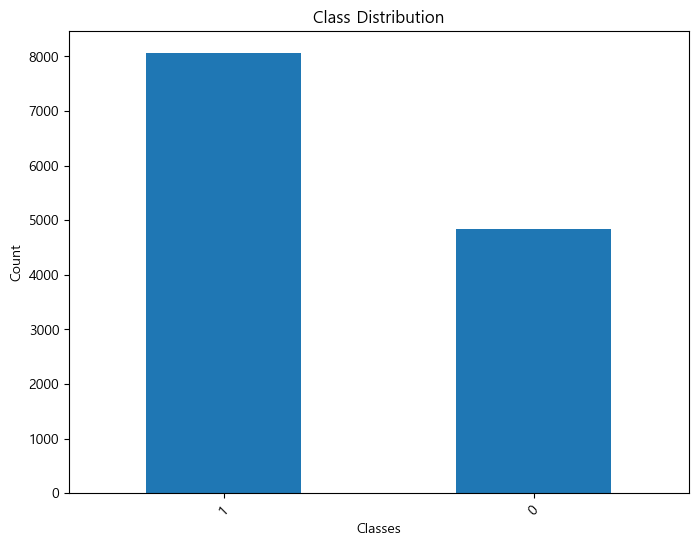

In [13]:
target = "DiagPeriodL90D"

# Count the occurrences of each class
class_counts = df[target].value_counts()

# Plot the class distribution
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [14]:
# 결측치 개수와 비율을 정리한 테이블 만들기
missing_df = pd.DataFrame({
    'Missing Values': df.isnull().sum(),
    'Missing Ratio (%)': (df.isnull().sum() / len(df)) * 100
})

# 결측치가 아예 없는 컬럼은 제외하고 보기
missing_df = missing_df[missing_df['Missing Values'] > 0]

# 결측치 많은 순으로 정렬
missing_df = missing_df.sort_values(by='Missing Values', ascending=False)

# 출력
display(missing_df)

,Missing Values,Missing Ratio (%)
metastatic_first_novel_treatment,12882,99.814040
metastatic_first_novel_treatment_type,12882,99.814040
bmi,8965,69.463815
patient_race,6385,49.473113
payer_type,1803,13.970246
...,...,...
race_other,1,0.007748
race_pacific,1,0.007748
commute_time,1,0.007748
health_uninsured,1,0.007748


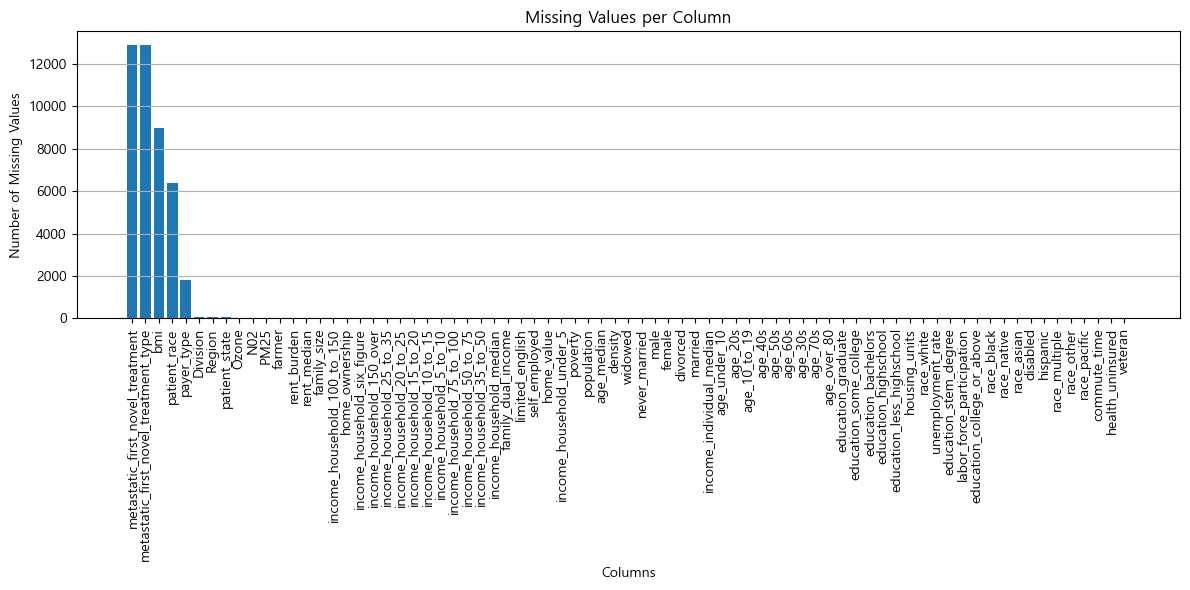

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# 결측치 개수 계산
missing_df = df.isnull().sum()

# 결측치가 있는 컬럼만 필터링
missing_df = missing_df[missing_df > 0]

# 결측치 개수 많은 순 정렬
missing_df = missing_df.sort_values(ascending=False)

# 시각화
plt.figure(figsize=(12, 6))
plt.bar(missing_df.index, missing_df.values)
plt.xticks(rotation=90)
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.title('Missing Values per Column')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [16]:
df.columns

Index(['patient_id', 'patient_race', 'payer_type', 'patient_state',
       'patient_zip3', 'patient_age', 'patient_gender', 'bmi',
       'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc',
       'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment',
       'metastatic_first_novel_treatment_type', 'Region', 'Division',
       'population', 'density', 'age_median', 'age_under_10', 'age_10_to_19',
       'age_20s', 'age_30s', 'age_40s', 'age_50s', 'age_60s', 'age_70s',
       'age_over_80', 'male', 'female', 'married', 'divorced', 'never_married',
       'widowed', 'family_size', 'family_dual_income',
       'income_household_median', 'income_household_under_5',
       'income_household_5_to_10', 'income_household_10_to_15',
       'income_household_15_to_20', 'income_household_20_to_25',
       'income_household_25_to_35', 'income_household_35_to_50',
       'income_household_50_to_75', 'income_household_75_to_100',
       'income_household_100_to_150', 'in

In [17]:
df['patient_gender'].value_counts()


# df['patient_gender'].isnull().sum()

patient_gender
F    12906
Name: count, dtype: int64

In [18]:
filtered_df = df[['metastatic_first_novel_treatment', 'DiagPeriodL90D']][df['metastatic_first_novel_treatment'].notnull()]
filtered_df

# DiagPeriodL90D 컬럼의 1과 0 비율 확인
ratio = filtered_df['DiagPeriodL90D'].value_counts(normalize=True)
print(ratio)


DiagPeriodL90D
1    0.666667
0    0.333333
Name: proportion, dtype: float64


In [19]:
df['breast_cancer_diagnosis_code'].value_counts()

breast_cancer_diagnosis_code
1749      1982
C50911    1797
C50912    1712
C50919    1467
C50411     978
C50412     877
C50811     491
C50812     419
1744       389
1748       307
C50212     293
C50211     276
C50511     213
C50112     209
C50111     208
C50512     176
C50312     159
C50311     138
C50011     108
C50012     105
1742        98
1741        88
1745        71
C50819      54
C50419      48
C5091       37
1743        34
C50612      29
C50611      25
C50319      16
C50019      13
1746        12
C50219      11
C50119      11
C5041        9
19881        9
C5081        8
C50519       8
C509         3
C50619       3
C50929       3
C5021        3
C5011        2
C5051        1
C50021       1
C5031        1
C50          1
1759         1
C5001        1
C50421       1
Name: count, dtype: int64

In [20]:
df['breast_cancer_diagnosis_desc'].value_counts()

breast_cancer_diagnosis_desc
Malignant neoplasm of breast (female), unspecified                  1982
Malignant neoplasm of unsp site of right female breast              1797
Malignant neoplasm of unspecified site of left female breast        1712
Malignant neoplasm of unsp site of unspecified female breast        1467
Malig neoplm of upper-outer quadrant of right female breast          978
Malig neoplasm of upper-outer quadrant of left female breast         877
Malignant neoplasm of ovrlp sites of right female breast             491
Malignant neoplasm of ovrlp sites of left female breast              419
Malignant neoplasm of upper-outer quadrant of female breast          389
Malignant neoplasm of other specified sites of female breast         307
Malig neoplasm of upper-inner quadrant of left female breast         293
Malig neoplm of upper-inner quadrant of right female breast          276
Malig neoplm of lower-outer quadrant of right female breast          213
Malignant neoplasm of 

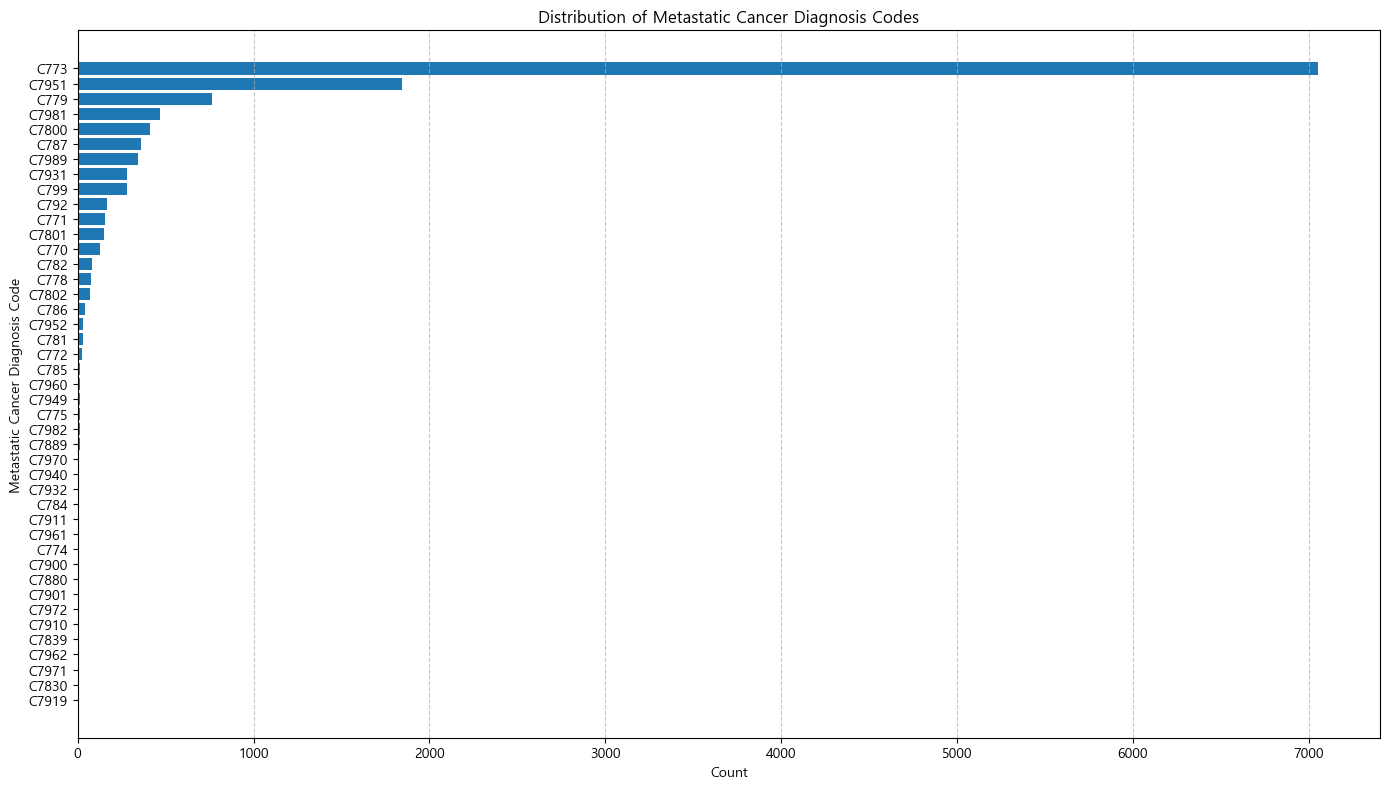

In [21]:
df_metastatic_cancer_diagnosis_code_counts = df['metastatic_cancer_diagnosis_code'].value_counts()

# 1. metastatic_cancer_diagnosis_code별 count 구하기
df_metastatic_cancer_diagnosis_code_counts = df['metastatic_cancer_diagnosis_code'].value_counts()

# 2. (이미 value_counts()가 내림차순이지만) 확실하게 정렬
df_counts = df_metastatic_cancer_diagnosis_code_counts.sort_values(ascending=False)

# 3. 시각화
plt.figure(figsize=(14, 8))
plt.barh(df_counts.index, df_counts.values)  # <-- index와 values로 접근
plt.xlabel('Count')
plt.ylabel('Metastatic Cancer Diagnosis Code')
plt.title('Distribution of Metastatic Cancer Diagnosis Codes')
plt.gca().invert_yaxis()  # 가장 많은 값이 위로
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [22]:
df[df['metastatic_first_novel_treatment'].notna()]['metastatic_first_novel_treatment'].value_counts()

metastatic_first_novel_treatment
PEMBROLIZUMAB    13
OLAPARIB         11
Name: count, dtype: int64

In [23]:
df[df['metastatic_first_novel_treatment_type'].notna()]['metastatic_first_novel_treatment_type'].value_counts()

metastatic_first_novel_treatment_type
Antineoplastics    24
Name: count, dtype: int64

## Race 관련 EDA 진행

In [25]:
df['patient_zip3'].value_counts()

patient_zip3
900    239
112    192
917    170
606    150
770    132
      ... 
860      1
261      1
835      1
668      1
163      1
Name: count, Length: 739, dtype: int64

In [26]:
cols = ['race_white', 'race_black', 'race_asian',
        'race_native', 'race_pacific', 'race_other', 'race_multiple']

df_first = df.loc[df['patient_zip3'] == 900, cols].iloc[0]

df_first

race_white       42.824615
race_black       12.216923
race_asian       12.703077
race_native       1.120000
race_pacific      0.146154
race_other       22.135385
race_multiple     8.850769
Name: 6, dtype: float64

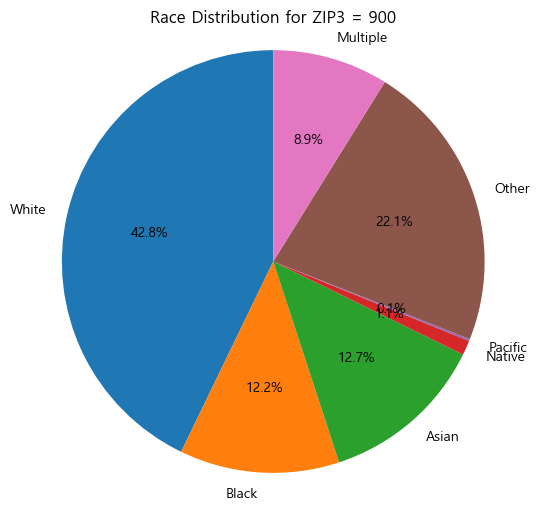

In [27]:
import matplotlib.pyplot as plt

# Data
labels = ['White', 'Black', 'Asian', 'Native', 'Pacific', 'Other', 'Multiple']
df_first

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(df_first, labels=labels, autopct='%1.1f%%', startangle=90)
ax.set_title('Race Distribution for ZIP3 = 900')
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [28]:
filtered_df = df[(df['patient_zip3'] == 900) & (df['patient_race'].notna())][['patient_race']]
filtered_df = filtered_df['patient_race'].value_counts(normalize=True)

labels = filtered_df.index
filtered_df.values
filtered_df

patient_race
Hispanic    0.339181
White       0.257310
Black       0.233918
Asian       0.099415
Other       0.070175
Name: proportion, dtype: float64

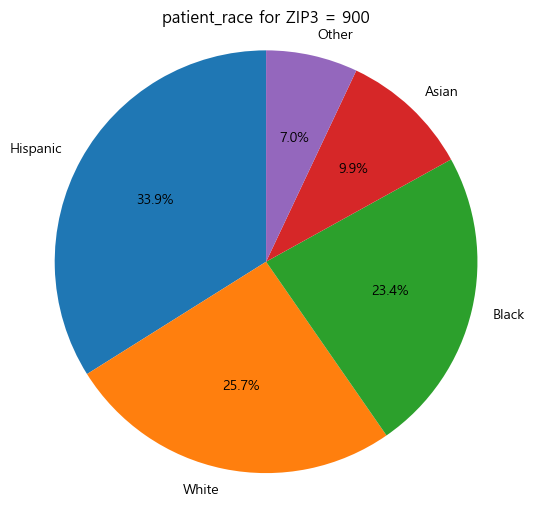

In [29]:
# Plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(filtered_df, labels=labels, autopct='%1.1f%%', startangle=90)
ax.set_title('patient_race for ZIP3 = 900')
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [30]:
df['patient_race'].value_counts(dropna=False)

patient_race
NaN         6385
White       3588
Black       1056
Hispanic     829
Other        683
Asian        365
Name: count, dtype: int64

In [31]:
import pandas as pd

# Region별 patient_race 분포(비율) 테이블
ratio_table = pd.crosstab(
    df['Region'],
    df['patient_race'],
    normalize='index'    # 행 기준 정규화 (비율)
)

display(ratio_table)

patient_race,Asian,Black,Hispanic,Other,White
Region,,,,,
Midwest,0.031188,0.142004,0.024552,0.070338,0.731918
Northeast,0.057592,0.208115,0.060209,0.087696,0.586387
South,0.023488,0.269365,0.126437,0.114943,0.465767
West,0.102124,0.063714,0.220063,0.125169,0.488929


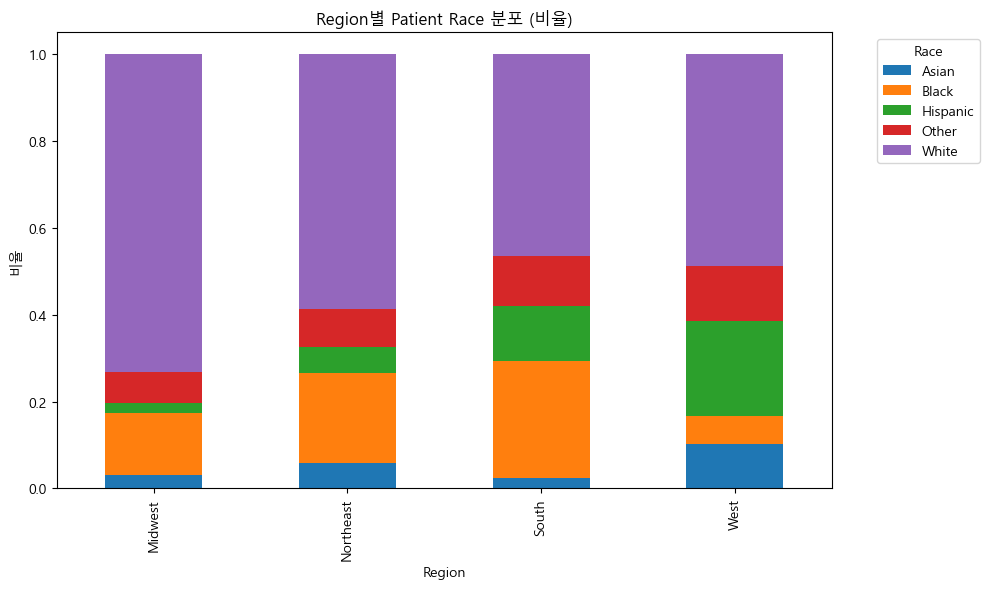

In [32]:
import matplotlib.pyplot as plt

# 위에서 만든 ratio_table 사용
ratio_table.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6)
)
plt.ylabel('비율')
plt.title('Region별 Patient Race 분포 (비율)')
plt.legend(title='Race', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


In [33]:
# 소문자로 변환한 뒤 'race' 포함 여부 체크
race_cols = [col for col in df.columns if 'race' in col.lower()]

display("race가 포함된 컬럼:", race_cols)

'race가 포함된 컬럼:'

['patient_race',
 'race_white',
 'race_black',
 'race_asian',
 'race_native',
 'race_pacific',
 'race_other',
 'race_multiple']

In [34]:
df.head()

,patient_id,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,...,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
0,475714,NaN,MEDICAID,CA,924,84,F,NaN,C50919,Malignant neoplasm of unsp site of unspecified female breast,...,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528,1
1,349367,White,COMMERCIAL,CA,928,62,F,28.49,C50411,Malig neoplm of upper-outer quadrant of right female breast,...,8.957576,10.109091,8.057576,30.606061,7.018182,4.103030,42.301121,8.487175,20.113179,1
2,138632,White,COMMERCIAL,TX,760,43,F,38.09,C50112,Malignant neoplasm of central portion of left female breast,...,11.253333,9.663333,3.356667,31.394915,15.066667,7.446667,40.108207,7.642753,14.839351,1
3,617843,White,COMMERCIAL,CA,926,45,F,NaN,C50212,Malig neoplasm of upper-inner quadrant of left female breast,...,8.845238,8.688095,5.280952,27.561905,4.404762,4.809524,42.070075,7.229393,15.894123,0
4,817482,NaN,COMMERCIAL,ID,836,55,F,NaN,1749,"Malignant neoplasm of breast (female), unspecified",...,15.276000,11.224000,1.946000,26.170213,12.088000,13.106000,41.356058,4.110749,11.722197,0


In [66]:
df[['patient_zip3', 'race_white', 'race_black',  'race_asian',  'race_native', 'race_pacific', 'race_other',  'race_multiple']]

,patient_zip3,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple
0,924,44.100000,13.100000,5.100000,1.485714,0.342857,27.114286,8.757143
1,928,54.030303,2.527273,20.827273,0.587879,0.300000,11.645455,10.081818
2,760,75.820000,9.231667,3.618333,0.463333,0.146667,3.816667,6.898333
3,926,65.014286,1.438095,18.845238,0.430952,0.252381,5.428571,8.611905
4,836,86.712000,0.426000,0.656000,0.760000,0.108000,5.080000,6.258000
...,...,...,...,...,...,...,...,...
12901,436,62.182353,27.770588,1.217647,0.270588,0.064706,2.476471,6.005882
12902,945,54.060494,5.906173,21.497531,0.586420,0.695062,7.986420,9.274074
12903,926,65.014286,1.438095,18.845238,0.430952,0.252381,5.428571,8.611905
12904,112,44.100000,28.831579,11.205263,0.515789,0.068421,9.184211,6.089474


In [68]:
df[['patient_age','patient_state' ,'patient_race']]

,patient_age,patient_state,patient_race
0,84,CA,NaN
1,62,CA,White
2,43,TX,White
3,45,CA,White
4,55,ID,NaN
...,...,...,...
12901,50,OH,White
12902,50,CA,NaN
12903,61,CA,NaN
12904,37,NY,NaN


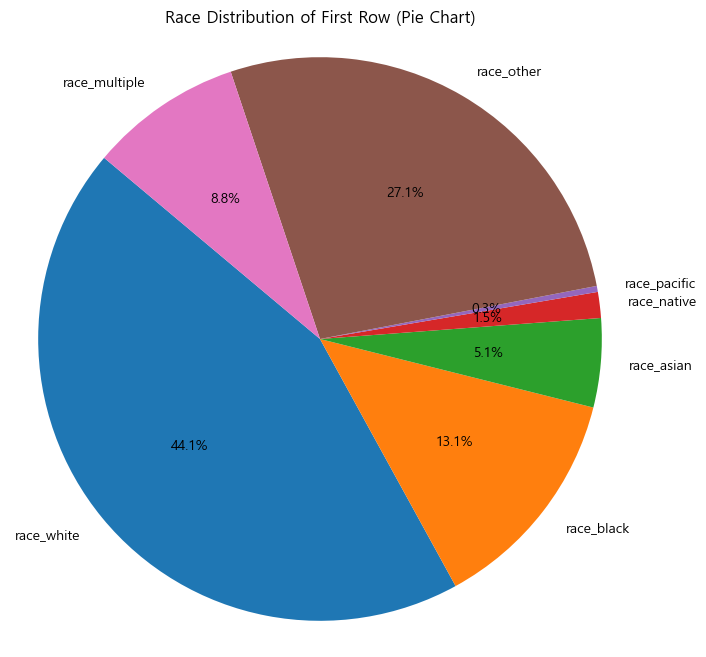

In [69]:
import matplotlib.pyplot as plt

# 사용할 컬럼 리스트 (patient_zip3 제외)
race_cols = ['race_white', 'race_black', 'race_asian', 'race_native', 
             'race_pacific', 'race_other', 'race_multiple']

# 첫 번째 행에서 race 데이터만 추출
first_row = df.loc[0, race_cols]

# NaN 값은 0으로 처리
first_row = first_row.fillna(0)

# 값이 모두 0이면 원그래프가 의미 없으니 확인
if first_row.sum() == 0:
    print("모든 값이 0입니다. 원그래프를 그릴 수 없습니다.")
else:
    # 시각화
    plt.figure(figsize=(8, 8))
    plt.pie(first_row.values, labels=first_row.index, autopct='%1.1f%%', startangle=140)
    plt.title('Race Distribution of First Row (Pie Chart)')
    plt.axis('equal')  # 동그란 원형 유지
    plt.show()


In [74]:
df['patient_zip3'] == 900
df[df['patient_zip3'] == 900]

,patient_id,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,...,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
6,914071,NaN,COMMERCIAL,CA,900,51,F,29.05,C50912,Malignant neoplasm of unspecified site of left female breast,...,11.901538,20.76,14.7375,30.709375,10.341538,3.030769,41.186992,11.166898,21.644261,1
11,343914,NaN,MEDICARE ADVANTAGE,CA,900,66,F,NaN,1749,"Malignant neoplasm of breast (female), unspecified",...,11.901538,20.76,14.7375,30.709375,10.341538,3.030769,41.186992,11.166898,21.644261,0
76,660003,Black,MEDICARE ADVANTAGE,CA,900,63,F,NaN,1749,"Malignant neoplasm of breast (female), unspecified",...,11.901538,20.76,14.7375,30.709375,10.341538,3.030769,41.186992,11.166898,21.644261,0
80,543669,Asian,MEDICARE ADVANTAGE,CA,900,73,F,NaN,C50212,Malig neoplasm of upper-inner quadrant of left female breast,...,11.901538,20.76,14.7375,30.709375,10.341538,3.030769,41.186992,11.166898,21.644261,0
174,569041,Hispanic,MEDICAID,CA,900,63,F,NaN,C50912,Malignant neoplasm of unspecified site of left female breast,...,11.901538,20.76,14.7375,30.709375,10.341538,3.030769,41.186992,11.166898,21.644261,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12608,348436,Black,MEDICAID,CA,900,63,F,NaN,C50911,Malignant neoplasm of unsp site of right female breast,...,11.901538,20.76,14.7375,30.709375,10.341538,3.030769,41.186992,11.166898,21.644261,1
12674,123890,Hispanic,MEDICAID,CA,900,60,F,NaN,C50912,Malignant neoplasm of unspecified site of left female breast,...,11.901538,20.76,14.7375,30.709375,10.341538,3.030769,41.186992,11.166898,21.644261,1
12715,313979,Hispanic,MEDICAID,CA,900,38,F,NaN,1748,Malignant neoplasm of other specified sites of female breast,...,11.901538,20.76,14.7375,30.709375,10.341538,3.030769,41.186992,11.166898,21.644261,0
12763,688510,Black,NaN,CA,900,76,F,30.00,C50412,Malig neoplasm of upper-outer quadrant of left female breast,...,11.901538,20.76,14.7375,30.709375,10.341538,3.030769,41.186992,11.166898,21.644261,1


In [76]:
len(df['patient_zip3'].unique())

739

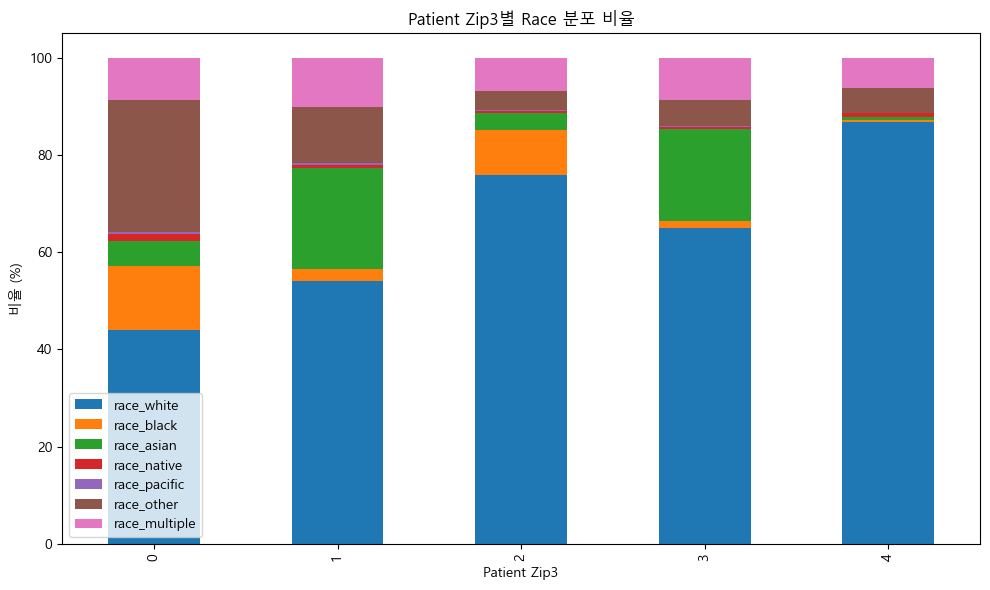

In [78]:
df_plot = pd.DataFrame({
    'race_white': [44.100000, 54.030303, 75.820000, 65.014286, 86.712000],
    'race_black': [13.100000,  2.527273,  9.231667,  1.438095,  0.426000],
    'race_asian': [5.100000, 20.827273,  3.618333, 18.845238,  0.656000],
    'race_native': [1.485714,  0.587879,  0.463333,  0.430952,  0.760000],
    'race_pacific': [0.342857,  0.300000,  0.146667,  0.252381,  0.108000],
    'race_other': [27.114286, 11.645455,  3.816667,  5.428571,  5.080000],
    'race_multiple': [8.757143, 10.081818,  6.898333,  8.611905,  6.258000],
})

# Plot stacked bar chart
ax = df_plot.plot(kind='bar', stacked=True, figsize=(10,6))
ax.set_ylabel('비율 (%)')
ax.set_xlabel('Patient Zip3')
ax.set_title('Patient Zip3별 Race 분포 비율')
plt.tight_layout()
plt.show()

### Chi-square Test(카이제곱 검정)
- 두 범주형 변수 간 독립성 검정
- patient_race vs Region

In [81]:
import pandas as pd
from scipy.stats import chi2_contingency

# 가정: df는 이미 로드된 상태입니다.
# 1) 교차표 생성
cont_table = pd.crosstab(df['Region'], df['patient_race'])

# 2) 카이제곱 독립성 검정 수행
chi2, p, dof, expected = chi2_contingency(cont_table)

# 3) 결과 출력
print("=== Contingency Table ===")
display(cont_table)

print("\n=== Chi-square Test Results ===")
print(f"Chi2 statistic: {chi2:.4f}")
print(f"p-value: {p:.4e}")
print(f"Degrees of freedom: {dof}")

print("\n=== Expected Frequencies ===")
expected_df = pd.DataFrame(expected, index=cont_table.index, columns=cont_table.columns)
display(expected_df)

=== Contingency Table ===


patient_race,Asian,Black,Hispanic,Other,White
Region,,,,,
Midwest,47,214,37,106,1103
Northeast,44,159,46,67,448
South,47,539,253,230,932
West,226,141,487,277,1082



=== Chi-square Test Results ===
Chi2 statistic: 891.3814
p-value: 4.0725e-183
Degrees of freedom: 12

=== Expected Frequencies ===


patient_race,Asian,Black,Hispanic,Other,White
Region,,,,,
Midwest,84.587201,244.698689,191.250732,158.020046,828.443331
Northeast,42.882961,124.054279,96.957903,80.111025,419.993832
South,112.315189,324.911796,253.943408,209.819584,1100.010023
West,124.214649,359.335235,280.847957,232.049345,1216.552814


In [83]:
from scipy.stats import chi2_contingency
import pandas as pd

# 교차표 생성
cont = pd.crosstab(df['Region'], df['patient_race'])
chi2, p, _, _ = chi2_contingency(cont)

print(f"p-value = {p:.4f}")

p-value = 0.0000


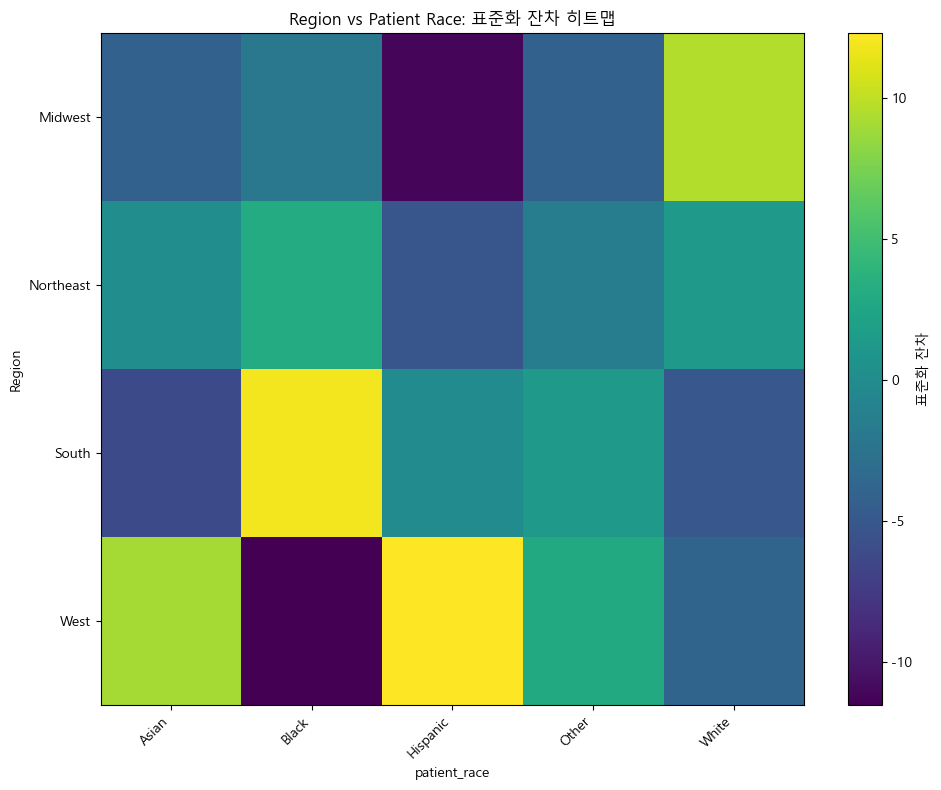

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import chi2_contingency

# 1) df가 이미 메모리에 로드된 상태여야 합니다.

# 2) 교차표 생성 및 기대빈도 계산
cont_table = pd.crosstab(df['Region'], df['patient_race'])
chi2, p, dof, expected = chi2_contingency(cont_table)

# 3) 표준화 잔차 계산
std_resid = (cont_table - expected) / np.sqrt(expected)

# 4) 히트맵 그리기
plt.figure(figsize=(10, 8))
plt.imshow(std_resid, aspect='auto')
plt.colorbar(label='표준화 잔차')
plt.xticks(np.arange(len(std_resid.columns)),
           std_resid.columns, rotation=45, ha='right')
plt.yticks(np.arange(len(std_resid.index)), std_resid.index)
plt.xlabel('patient_race')
plt.ylabel('Region')
plt.title('Region vs Patient Race: 표준화 잔차 히트맵')
plt.tight_layout()
plt.show()


In [81]:
df['race_white']

0        44.100000
1        54.030303
2        75.820000
3        65.014286
4        86.712000
           ...    
12901    62.182353
12902    54.060494
12903    65.014286
12904    44.100000
12905    62.651852
Name: race_white, Length: 12906, dtype: float64

In [83]:
cond1 = df['patient_race'].isna()
cond2 = df['patient_zip3'] == 924

df[cond1 & cond2]

,patient_id,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,...,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
0,475714,NaN,MEDICAID,CA,924,84,F,NaN,C50919,Malignant neoplasm of unsp site of unspecified female breast,...,12.871429,22.542857,10.1,27.814286,11.2,3.5,52.23721,8.650555,18.606528,1


In [84]:
df[df['patient_zip3'] == 924]

,patient_id,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,...,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
0,475714,NaN,MEDICAID,CA,924,84,F,NaN,C50919,Malignant neoplasm of unsp site of unspecified female breast,...,12.871429,22.542857,10.1,27.814286,11.2,3.5,52.23721,8.650555,18.606528,1
422,224431,Hispanic,NaN,CA,924,41,F,38.11,1749,"Malignant neoplasm of breast (female), unspecified",...,12.871429,22.542857,10.1,27.814286,11.2,3.5,52.23721,8.650555,18.606528,0
482,805693,Hispanic,COMMERCIAL,CA,924,44,F,NaN,C50412,Malig neoplasm of upper-outer quadrant of left female breast,...,12.871429,22.542857,10.1,27.814286,11.2,3.5,52.23721,8.650555,18.606528,1
721,103466,Black,MEDICAID,CA,924,49,F,NaN,C50912,Malignant neoplasm of unspecified site of left female breast,...,12.871429,22.542857,10.1,27.814286,11.2,3.5,52.23721,8.650555,18.606528,1
1687,361277,Black,MEDICARE ADVANTAGE,CA,924,83,F,NaN,C50912,Malignant neoplasm of unspecified site of left female breast,...,12.871429,22.542857,10.1,27.814286,11.2,3.5,52.23721,8.650555,18.606528,1
2400,938380,Hispanic,MEDICARE ADVANTAGE,CA,924,76,F,NaN,1749,"Malignant neoplasm of breast (female), unspecified",...,12.871429,22.542857,10.1,27.814286,11.2,3.5,52.23721,8.650555,18.606528,0
4961,776601,White,COMMERCIAL,CA,924,40,F,24.45,C50419,Malig neoplasm of upper-outer quadrant of unsp female breast,...,12.871429,22.542857,10.1,27.814286,11.2,3.5,52.23721,8.650555,18.606528,1
5930,255371,Hispanic,NaN,CA,924,60,F,NaN,C50912,Malignant neoplasm of unspecified site of left female breast,...,12.871429,22.542857,10.1,27.814286,11.2,3.5,52.23721,8.650555,18.606528,1
6522,947684,Asian,MEDICAID,CA,924,36,F,NaN,C50912,Malignant neoplasm of unspecified site of left female breast,...,12.871429,22.542857,10.1,27.814286,11.2,3.5,52.23721,8.650555,18.606528,0
7696,336594,Black,MEDICAID,CA,924,66,F,NaN,C50919,Malignant neoplasm of unsp site of unspecified female breast,...,12.871429,22.542857,10.1,27.814286,11.2,3.5,52.23721,8.650555,18.606528,0


In [92]:
# zip2 만들기
df['zip2'] = df['patient_zip3'].astype(str).str[:2]

In [94]:
df['zip2']

0        92
1        92
2        76
3        92
4        83
         ..
12901    43
12902    94
12903    92
12904    11
12905    33
Name: zip2, Length: 12906, dtype: object

In [96]:
# 지역 매핑
zip2_region = {
    '00': 'Massachusetts', '01': 'Massachusetts', '02': 'Massachusetts', '03': 'New Hampshire', '04': 'Maine',
    '05': 'Vermont', '06': 'Connecticut', '07': 'New Jersey', '08': 'New Jersey', '09': 'Military (Europe)',
    '10': 'Delaware', '11': 'District of Columbia', '12': 'Virginia', '13': 'Virginia', '14': 'Virginia',
    '15': 'Pennsylvania', '16': 'Pennsylvania', '17': 'Pennsylvania', '18': 'Pennsylvania', '19': 'Pennsylvania',
    '20': 'Maryland', '21': 'Maryland', '22': 'Maryland', '23': 'Delaware', '24': 'Maryland',
    '25': 'Virginia', '26': 'South Carolina', '27': 'North Carolina', '28': 'North Carolina', '29': 'South Carolina',
    '30': 'Ohio', '31': 'Ohio', '32': 'Ohio', '33': 'Michigan', '34': 'Michigan',
    '35': 'New York (Upstate)', '36': 'New York (Upstate)', '37': 'New York (Upstate)', '38': 'New York (Upstate)', '39': 'New York (Upstate)',
    '40': 'Kentucky', '41': 'Tennessee', '42': 'Pennsylvania', '43': 'Ohio', '44': 'Michigan',
    '45': 'South Carolina', '46': 'North Carolina', '47': 'Tennessee', '48': 'Alabama', '49': 'Georgia',
    '50': 'Iowa', '51': 'Iowa', '52': 'Iowa', '53': 'Minnesota', '54': 'Wisconsin', '55': 'Wisconsin',
    '56': 'North Dakota', '57': 'South Dakota', '58': 'Nebraska', '59': 'Nebraska',
    '60': 'Illinois', '61': 'Illinois', '62': 'Illinois', '63': 'Missouri', '64': 'Missouri',
    '65': 'Kentucky', '66': 'Kansas', '67': 'Missouri', '68': 'Arkansas', '69': 'Arkansas',
    '70': 'New Jersey', '71': 'New Jersey', '72': 'Puerto Rico', '73': 'New Jersey', '74': 'New Jersey',
    '75': 'Texas (Dallas)', '76': 'Texas (Fort Worth)', '77': 'Texas (Houston)', '78': 'Texas (Austin/San Antonio)', '79': 'Texas (West)',
    '80': 'North Dakota', '81': 'South Dakota', '82': 'Nebraska', '83': 'Idaho', '84': 'Utah',
    '85': 'Arizona', '86': 'Arizona', '87': 'New Mexico', '88': 'Colorado', '89': 'Wyoming',
    '90': 'California (Southern)', '91': 'California (Southern)', '92': 'California (Northern)',
    '93': 'California (Southern)', '94': 'California (Northern)', '95': 'California (Northern)',
    '96': 'Military (Pacific)', '97': 'Oregon', '98': 'Washington', '99': 'Washington'
}

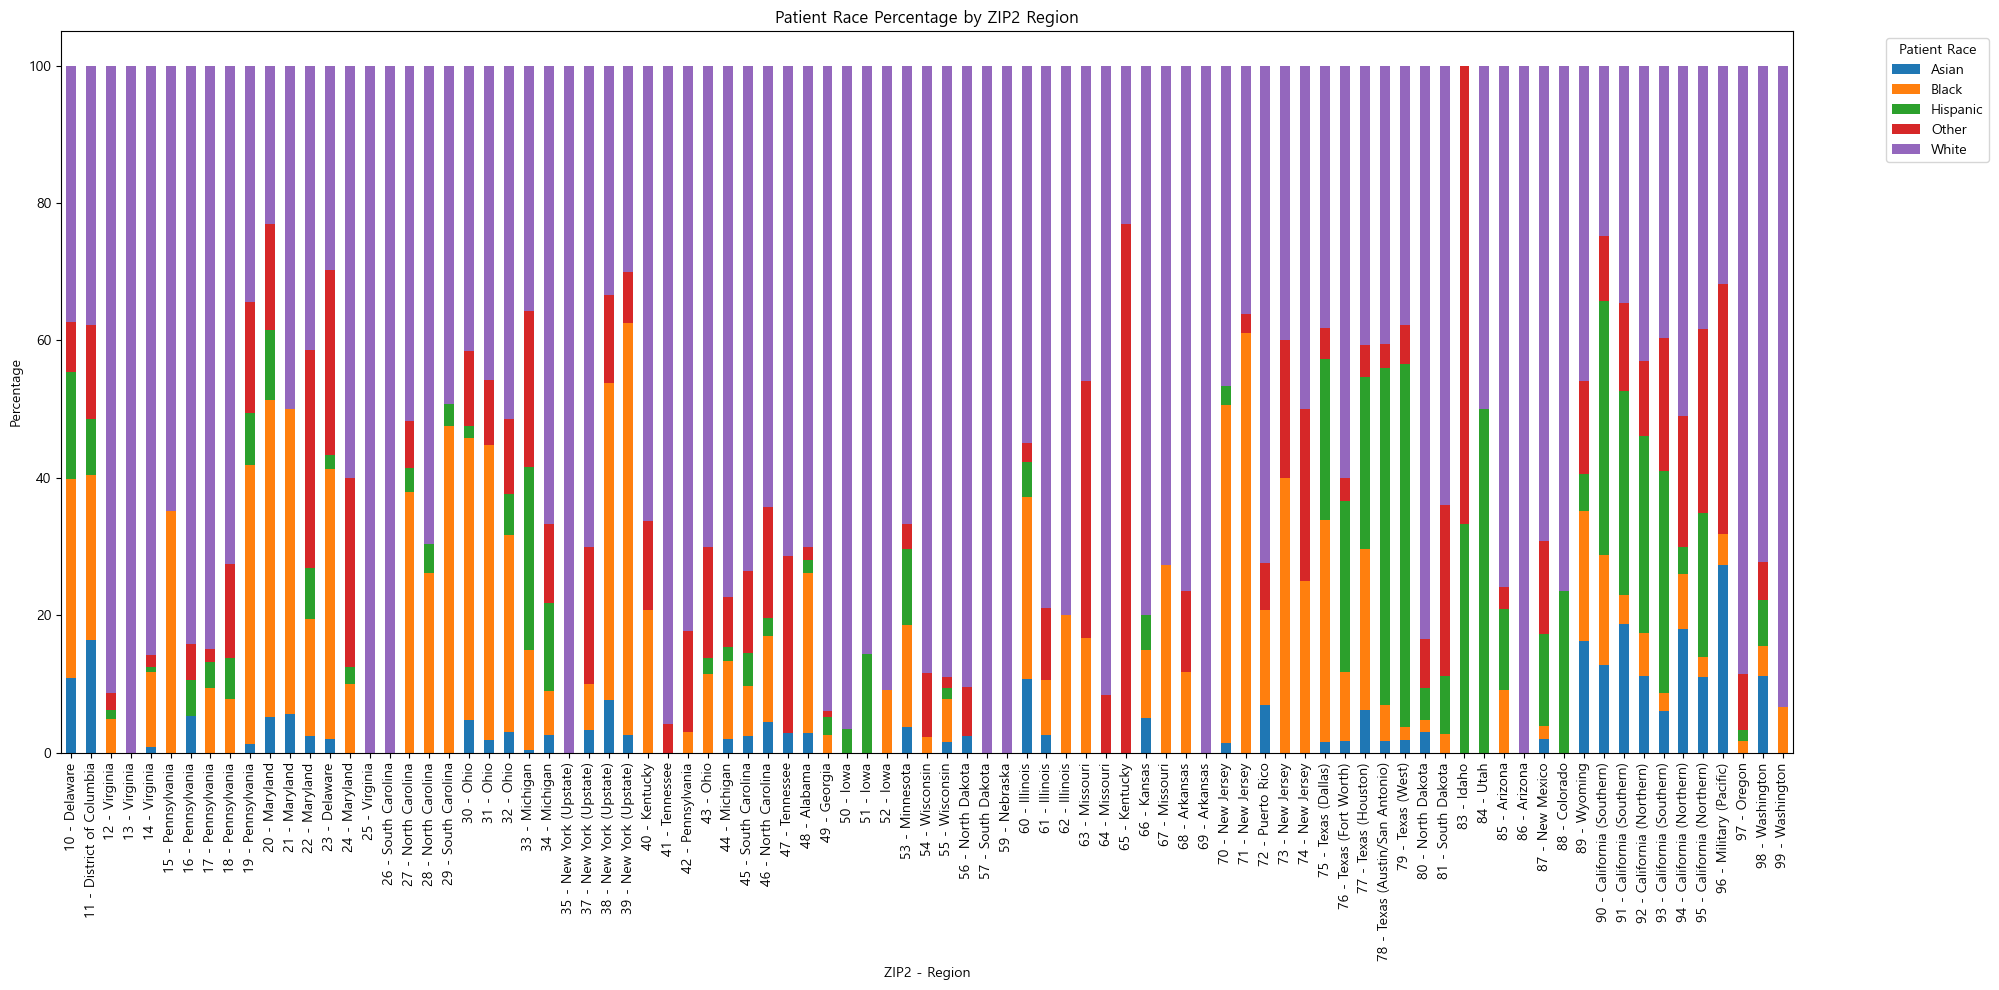

In [98]:
# zip2를 지역 이름으로 매핑
df['지역'] = df['zip2'].map(zip2_region).fillna('Unknown')
df['zip2_label'] = df['zip2'] + ' - ' + df['지역']

# patient_race별 zip2 분포
race_zip2_ct = pd.crosstab(df['zip2_label'], df['patient_race'])

# 퍼센트로 변환
race_zip2_pct = race_zip2_ct.div(race_zip2_ct.sum(axis=1), axis=0) * 100

# 막대그래프
race_zip2_pct.plot(kind='bar', stacked=True, figsize=(20, 10))

plt.title('Patient Race Percentage by ZIP2 Region')
plt.xlabel('ZIP2 - Region')
plt.ylabel('Percentage')
plt.legend(title='Patient Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [159]:
df[df['zip2'] == '12']['patient_race'].value_counts(dropna=False)

patient_race
White       74
NaN         68
Black        4
Other        2
Hispanic     1
Name: count, dtype: int64

In [155]:
df[df['zip2'] == '99']['patient_race'].value_counts(dropna=False)

patient_race
NaN      26
White    14
Black     1
Name: count, dtype: int64

In [161]:
df[df['zip2'] == '84']['patient_race'].value_counts(dropna=False)

patient_race
NaN         26
White        5
Hispanic     5
Name: count, dtype: int64

In [165]:
df['patient_race'].value_counts(dropna=False)

patient_race
NaN         6385
White       3588
Black       1056
Hispanic     829
Other        683
Asian        365
Name: count, dtype: int64

### breast_cancer_code & desc

In [90]:
display(df.groupby('breast_cancer_diagnosis_code')['breast_cancer_diagnosis_desc'].unique())

breast_cancer_diagnosis_code
1741                [Malignant neoplasm of central portion of female breast]
1742           [Malignant neoplasm of upper-inner quadrant of female breast]
1743           [Malignant neoplasm of lower-inner quadrant of female breast]
1744           [Malignant neoplasm of upper-outer quadrant of female breast]
1745           [Malignant neoplasm of lower-outer quadrant of female breast]
1746                  [Malignant neoplasm of axillary tail of female breast]
1748          [Malignant neoplasm of other specified sites of female breast]
1749                    [Malignant neoplasm of breast (female), unspecified]
1759      [Malignant neoplasm of other and unspecified sites of male breast]
19881                               [Secondary malignant neoplasm of breast]
C50                                           [Malignant neoplasm of breast]
C5001                      [Malignant neoplasm of nipple and areola, female]
C50011        [Malignant neoplasm of nipple and

In [121]:
df['breast_cancer_diagnosis_code']

0        C50919
1        C50411
2        C50112
3        C50212
4          1749
          ...  
12901    C50411
12902    C50912
12903    C50912
12904      1749
12905    C50412
Name: breast_cancer_diagnosis_code, Length: 12906, dtype: object

### 파생변수 생성

### age와의 관계 확인 

In [92]:
df['patient_age'].value_counts(dropna=False)

patient_age
60    471
63    468
62    458
61    451
64    434
     ... 
18      8
23      6
19      5
20      4
21      3
Name: count, Length: 67, dtype: int64

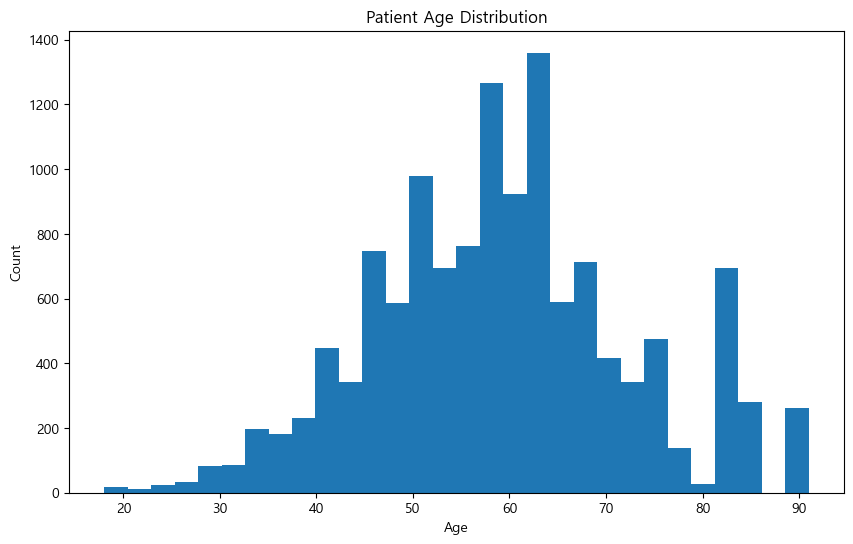

In [96]:
import matplotlib.pyplot as plt

# df['patient_age'] 히스토그램 그리기
plt.figure(figsize=(10, 6))
plt.hist(df['patient_age'].dropna(), bins=30)
plt.title('Patient Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

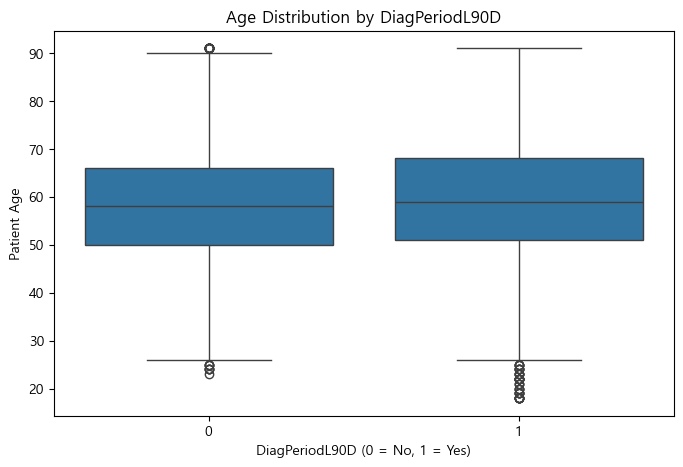

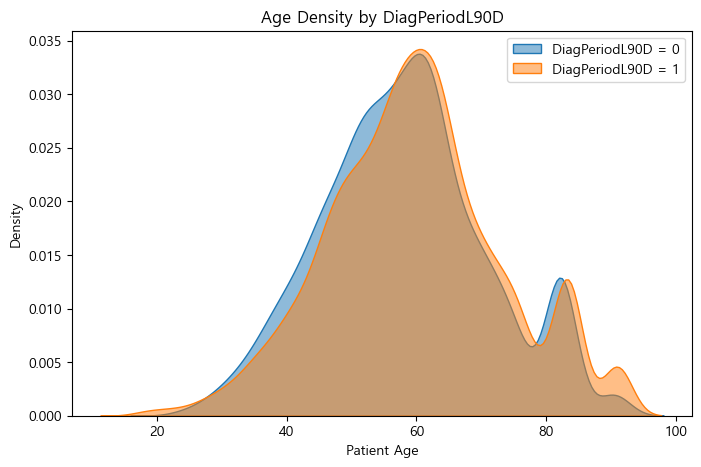

                 mean_age  median_age  count
DiagPeriodL90D                              
0               58.226579        58.0   4846
1               59.758561        59.0   8060


In [104]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1) 필요한 컬럼만 추출하고 결측치 제거
data = df[['DiagPeriodL90D', 'patient_age']].dropna()

# 2) 박스플롯으로 비교
plt.figure(figsize=(8, 5))
sns.boxplot(
    x='DiagPeriodL90D',
    y='patient_age',
    data=data
)
plt.title('Age Distribution by DiagPeriodL90D')
plt.xlabel('DiagPeriodL90D (0 = No, 1 = Yes)')
plt.ylabel('Patient Age')
plt.show()

# 3) KDE(커널 밀도)로 분포 겹쳐 보기
plt.figure(figsize=(8, 5))
for grp in [0, 1]:
    subset = data[data['DiagPeriodL90D'] == grp]['patient_age']
    sns.kdeplot(
        subset,
        label=f'DiagPeriodL90D = {grp}',
        fill=True,
        alpha=0.5
    )
plt.title('Age Density by DiagPeriodL90D')
plt.xlabel('Patient Age')
plt.legend()
plt.show()

# 4) 통계적 요약
summary = data.groupby('DiagPeriodL90D')['patient_age'].agg(
    mean_age='mean',
    median_age='median',
    count='count'
)
print(summary)


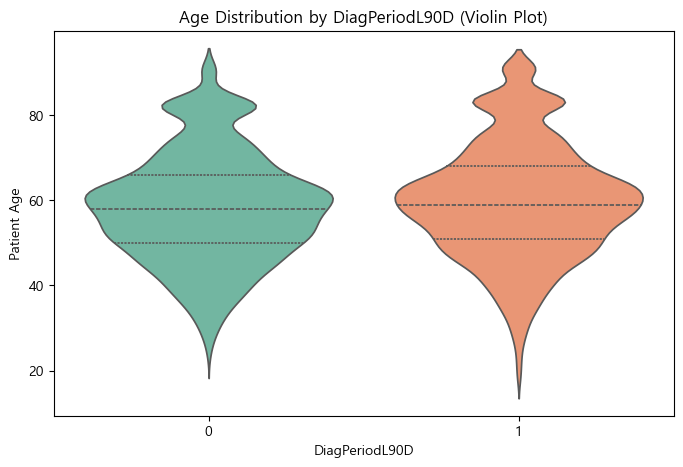

In [108]:
plt.figure(figsize=(8,5))
sns.violinplot(x='DiagPeriodL90D', y='patient_age', data=df, inner='quartile', palette='Set2')
plt.title('Age Distribution by DiagPeriodL90D (Violin Plot)')
plt.xlabel('DiagPeriodL90D')
plt.ylabel('Patient Age')
plt.show()

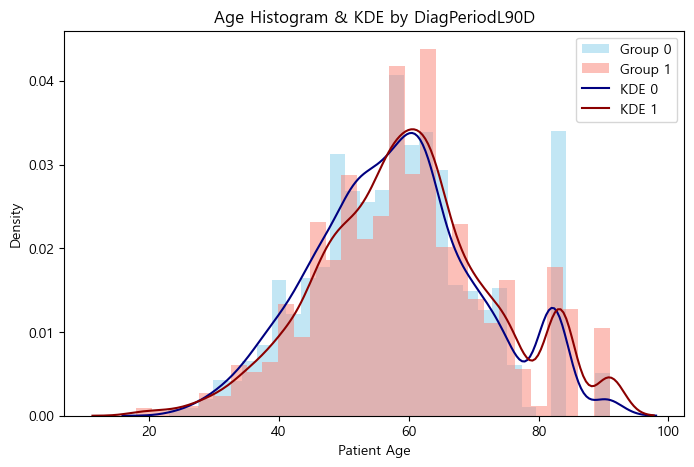

In [110]:
plt.figure(figsize=(8,5))
# Histogram overlay
for grp, color in zip([0,1], ['skyblue','salmon']):
    ages = df.loc[df['DiagPeriodL90D']==grp, 'patient_age'].dropna()
    plt.hist(ages, bins=30, alpha=0.5, label=f'Group {grp}', density=True, color=color)

# KDE overlay
for grp, color in zip([0,1], ['navy','darkred']):
    sns.kdeplot(df.loc[df['DiagPeriodL90D']==grp, 'patient_age'], label=f'KDE {grp}', color=color)

plt.title('Age Histogram & KDE by DiagPeriodL90D')
plt.xlabel('Patient Age')
plt.ylabel('Density')
plt.legend()
plt.show()


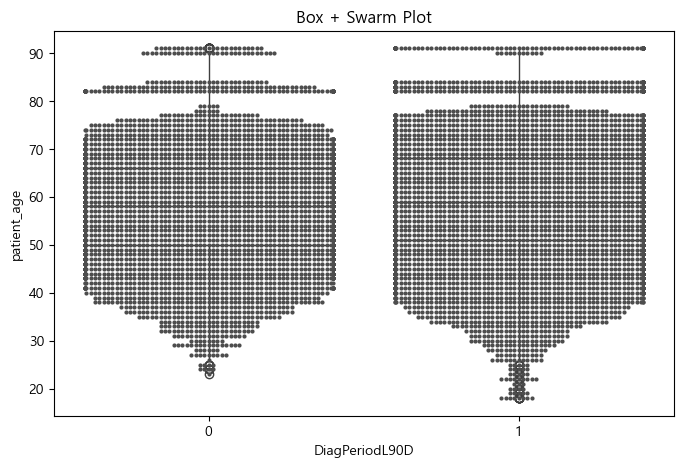

In [112]:
plt.figure(figsize=(8,5))
sns.boxplot(x='DiagPeriodL90D', y='patient_age', data=df, showcaps=False, boxprops={'facecolor':'None'})
sns.swarmplot(x='DiagPeriodL90D', y='patient_age', data=df, size=3, color='.3')
plt.title('Box + Swarm Plot')
plt.show()

In [106]:
import scipy.stats as stats

# 1) 데이터 준비
age0 = df.loc[df['DiagPeriodL90D']==0, 'patient_age'].dropna()
age1 = df.loc[df['DiagPeriodL90D']==1, 'patient_age'].dropna()

# 2) Welch’s t-test 수행 (equal_var=False)
t_stat, p_value = stats.ttest_ind(age0, age1, equal_var=False)

print(f"t-statistic: {t_stat:.3f}")
print(f"p-value: {p_value:.4f}")


t-statistic: -6.405
p-value: 0.0000


### patient_race와 DiagPeriodL90D의 관계

In [116]:
df['patient_race']

0             NaN
1           White
2           White
3           White
4             NaN
           ...   
12901       White
12902         NaN
12903         NaN
12904         NaN
12905    Hispanic
Name: patient_race, Length: 12906, dtype: object

In [119]:
df['patient_race_f'] = df['patient_race'].fillna('Missing')

In [121]:
import pandas as pd

# fillna 방식 예시 사용
data = df[['patient_race_f', 'DiagPeriodL90D']]

# 건수 교차표
ct = pd.crosstab(data['patient_race_f'], data['DiagPeriodL90D'])
print(ct)

# 비율 교차표 (행 기준 백분율)
ct_pct = ct.div(ct.sum(axis=1), axis=0) * 100
print(ct_pct.round(2))

DiagPeriodL90D     0     1
patient_race_f            
Asian            135   230
Black            408   648
Hispanic         305   524
Missing         2520  3865
Other            255   428
White           1223  2365
DiagPeriodL90D      0      1
patient_race_f              
Asian           36.99  63.01
Black           38.64  61.36
Hispanic        36.79  63.21
Missing         39.47  60.53
Other           37.34  62.66
White           34.09  65.91


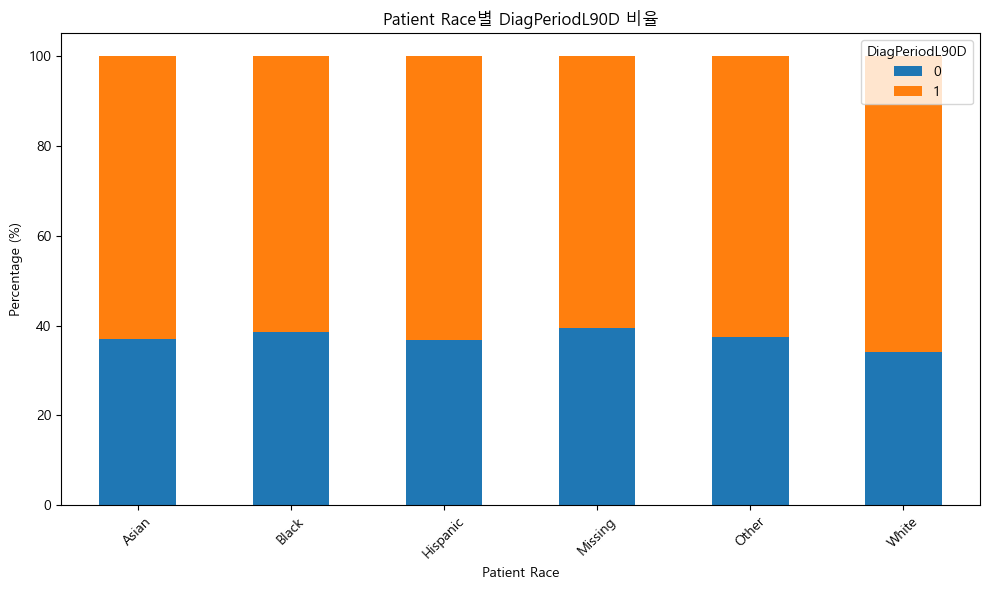

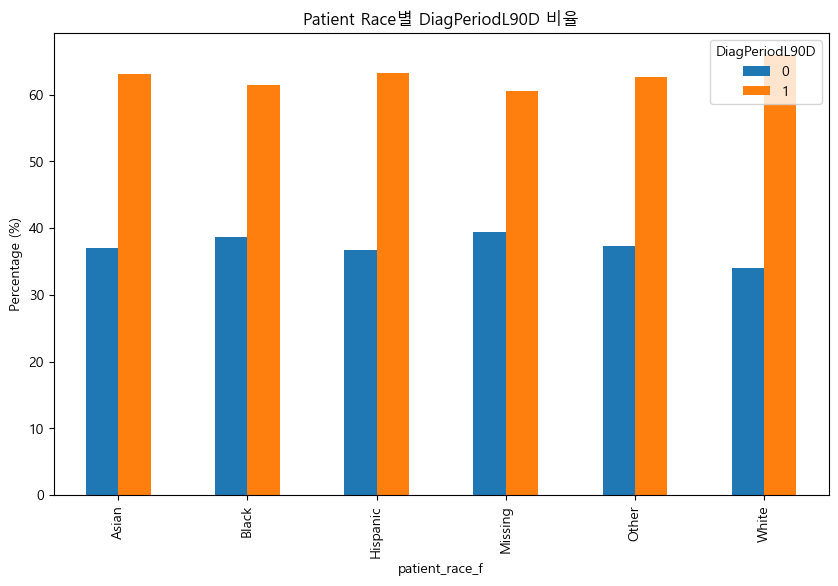

In [123]:
import matplotlib.pyplot as plt

# (1) 누적 막대그래프
ct_pct.plot(
    kind='bar',
    stacked=True,
    figsize=(10,6)
)
plt.title('Patient Race별 DiagPeriodL90D 비율')
plt.xlabel('Patient Race')
plt.ylabel('Percentage (%)')
plt.legend(title='DiagPeriodL90D', loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# (2) 그룹별 백분율 막대그래프 (side-by-side)
ct_pct.plot(
    kind='bar',
    figsize=(10,6)
)
plt.title('Patient Race별 DiagPeriodL90D 비율')
plt.ylabel('Percentage (%)')
plt.show()


In [125]:
from scipy.stats import chi2_contingency

# 실제 건수 교차표(ct) 사용
chi2, p, dof, expected = chi2_contingency(ct)

print(f"Chi2 statistic: {chi2:.2f}")
print(f"p-value: {p:.4f}")


Chi2 statistic: 29.17
p-value: 0.0000


In [129]:
import pandas as pd

# 교차표: 건수
ct = pd.crosstab(df['patient_race_f'], df['DiagPeriodL90D'])

# 백분율(행 기준)
ct_pct = ct.div(ct.sum(axis=1), axis=0) * 100

# 재진단 비율만 추출
re_diag_pct = ct_pct[1].sort_values(ascending=False)
print(re_diag_pct)


patient_race_f
White       65.914158
Hispanic    63.208685
Asian       63.013699
Other       62.664714
Black       61.363636
Missing     60.532498
Name: 1, dtype: float64


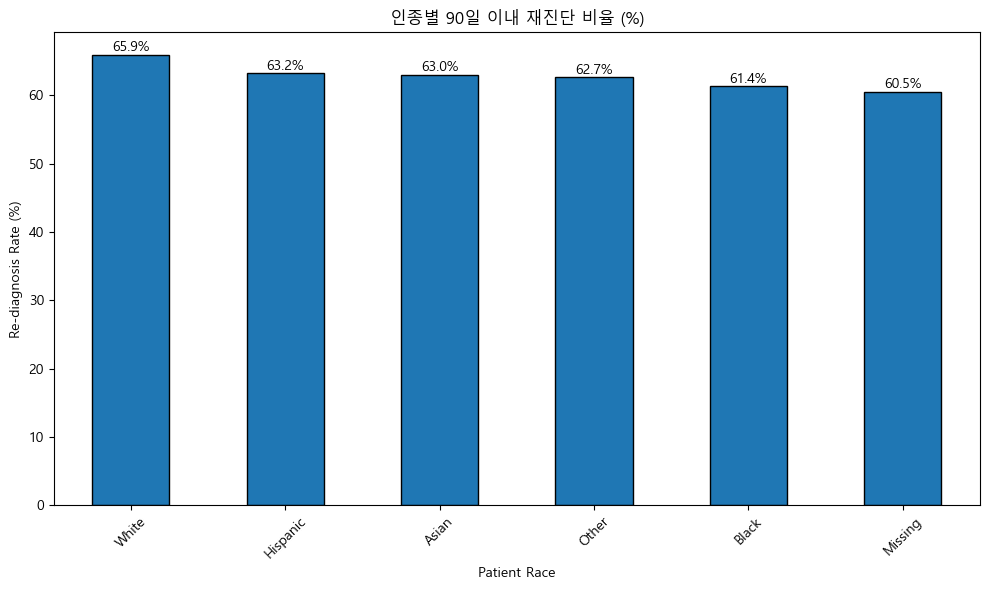

In [131]:
import matplotlib.pyplot as plt

# (1) 재진단 비율만 뽑아서 시각화
plt.figure(figsize=(10,6))
re_diag_pct.plot(
    kind='bar',
    edgecolor='black'
)
plt.title('인종별 90일 이내 재진단 비율 (%)')
plt.xlabel('Patient Race')
plt.ylabel('Re-diagnosis Rate (%)')
plt.xticks(rotation=45)
# 막대 위에 비율 텍스트 표시
for idx, val in enumerate(re_diag_pct):
    plt.text(idx, val + 0.5, f"{val:.1f}%", ha='center')
plt.tight_layout()
plt.show()


- # Data Cleaning

Zip code level metadata were dropped except product of N02,PM25 & Ozone

Data set contained missing values which we left unhandled


In [94]:
#  Find Product of Pollutants
df["N02xOzonexPM25"]=df["N02"]*df["Ozone"]*df["PM25"]
tdf["N02xOzonexPM25"]=tdf["N02"]*tdf["Ozone"]*tdf["PM25"]

In [49]:
# Drop some features
# List of columns to iterate over
columns_to_iterate = [col for col in df.columns if col not in ["patient_zip3", "N02xOzonexPM25"]]

# Iterate over each column
for col in columns_to_iterate:
    # Your code to operate on each column goes here
    df["check"]=df.groupby(["patient_zip3","N02xOzonexPM25"])[col].transform("nunique")
    if df["check"].max()==1:
        print("dropped ",col)
        df=df.drop(col,axis=1)
        tdf=tdf.drop(col,axis=1)
df=df.drop("check",axis=1)

dropped  patient_gender
dropped  metastatic_first_novel_treatment
dropped  metastatic_first_novel_treatment_type
dropped  population
dropped  density
dropped  age_median
dropped  age_under_10
dropped  age_10_to_19
dropped  age_20s
dropped  age_30s
dropped  age_40s
dropped  age_50s
dropped  age_60s
dropped  age_70s
dropped  age_over_80
dropped  male
dropped  female
dropped  married
dropped  divorced
dropped  never_married
dropped  widowed
dropped  family_size
dropped  family_dual_income
dropped  income_household_median
dropped  income_household_under_5
dropped  income_household_5_to_10
dropped  income_household_10_to_15
dropped  income_household_15_to_20
dropped  income_household_20_to_25
dropped  income_household_25_to_35
dropped  income_household_35_to_50
dropped  income_household_50_to_75
dropped  income_household_75_to_100
dropped  income_household_100_to_150
dropped  income_household_150_over
dropped  income_household_six_figure
dropped  income_individual_median
dropped  home_owner

In [212]:
'patient_id', 'patient_race', 'payer_type', 'patient_state',
'patient_zip3', 'patient_age', 'bmi', 'breast_cancer_diagnosis_desc',
'metastatic_cancer_diagnosis_code', 'Region', 'Division',
'DiagPeriodL90D', 'N02xOzonexPM25', 'clust', 'is_female'

('DiagPeriodL90D', 'N02xOzonexPM25', 'clust', 'is_female')

삭제되는 컬럼과 채우고자 컬럼간의 관계를 통해 imputation 활용 

In [50]:
# define target variable and categorical features
cat_cols = list(tdf.columns[tdf.dtypes=="object"])
cols = [col for col in tdf.columns if col not in ["patient_id"]]
tdf[target] = np.nan

In [ ]:
# concatenate train and test set
df = pd.concat([df,tdf[df.columns]],axis=0)

- # Feature Engineering

We then combined various pollutants into a single feature.

Our goal was to capture the overall environmental impact in a more digestible form for our models. Additionally, we introduced flags for critical variables:

A flag for metastatic_cancer_diagnosis_code with a length of 4 to identify specific diagnosis codes of interest.

A flag for breast_cancer_diagnosis_desc containing the term "female". 

We applied one-hot encoding to a carefully selected set of features, including payer_type, patient_race, and breast_cancer_diagnosis_desc, among others

In [ ]:
df["clust"]=(df.metastatic_cancer_diagnosis_code.str.len()==4).astype("int")
df["is_female"] = df.breast_cancer_diagnosis_desc.str.contains("female").astype("int")
df["is_female"].value_counts()

In [ ]:
# Count the occurrences of each class
clust_counts = df["clust"].value_counts()

# Plot the clust distribution
plt.figure(figsize=(8, 6))
clust_counts.plot(kind='bar')
plt.title('Clust Distribution')
plt.xlabel('Clust')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# do one-hot encoding for some features
age_cols = list(df.filter(regex="age").columns)
cols = list(set(cols)-set(age_cols))
income_cols = list(df.filter(regex="income").columns)
cols = list(set(cols)-set(income_cols))
cols = list(set(cols)-{"breast_cancer_diagnosis_code","N02xOzonexPM25","bmi"})
df=pd.get_dummies(df,columns=cols,dtype="int",drop_first=True)
cols

In [99]:
# do label encoding for categorical columns
le=LabelEncoder()
for col in cat_cols:
    try:
        df[col]=le.fit_transform(df[col]).astype("int")
        print(col)
    except:
        continue

breast_cancer_diagnosis_code


In [100]:
tdf=df[df[target].isna()]
df=df[df[target].notna()]
len(df),len(tdf)

(12906, 5792)

- # Modelling

Our model architecture consisted of base models and a meta-model:

Base Models: We utilized two CatBoost models and one XGBoost model.

These models were chosen for their robust handling of categorical features and their ability to handle the missing data in our dataset.


Meta-Model: A Logistic Regression model served as our meta-model.

In [22]:
modela = CatBoostClassifier(iterations=500, silent=True, learning_rate=0.05, depth=10, eval_metric='AUC', random_seed=42)
modelb = CatBoostClassifier(iterations=500, silent=True, learning_rate=0.05, depth=10, eval_metric='AUC', random_seed=42)
model2a = XGBClassifier(
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    subsample=0.9
)

In [23]:
# finalize features for training
drop_cols=["patient_id",target,"patient_zip3","patient_state"]
cols=list(set(df.columns)-set(drop_cols))

In [24]:
# Define the number of folds
num_folds = 10
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

In [25]:
# use stacking method, define meta model
from sklearn.linear_model import LogisticRegression
meta_model = LogisticRegression()
meta_features=['pred1b','pred2','pred1']

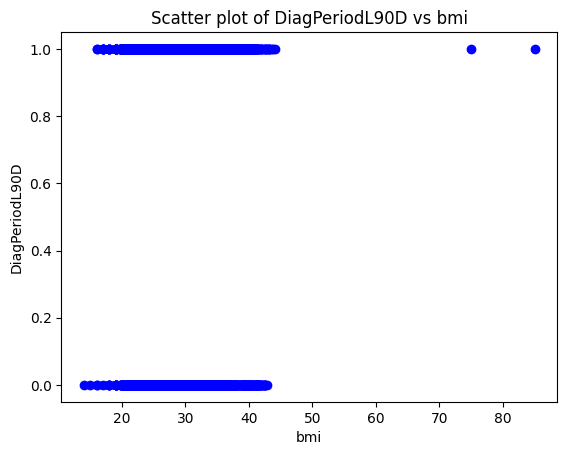

In [26]:
import pandas as pd
import matplotlib.pyplot as plt


# Plotting
plt.scatter(df['bmi'], df[target], color='blue')
plt.xlabel('bmi')
plt.ylabel(target)
plt.title(f'Scatter plot of {target} vs bmi')
plt.savefig('bmi.png')
plt.show()


In [27]:
# Initialize empty dataframe to store predictions from all folds
predictions_from_folds=pd.DataFrame()
# Iterate over foldsa
for fold, (train_index, val_index) in enumerate(kf.split(df, df[target])):
    dfx, efx = df.iloc[train_index], df.iloc[val_index]
    # train and make predictions on train set
    efx["pred1"] = modela.fit(dfx[cols].values, dfx[target]).predict_proba(efx[cols].values)[:,1]
    efx["pred2"] = modelb.fit(dfx[cols].values, dfx[target]).predict_proba(efx[cols].values)[:,1]
    efx["pred1b"] = model2a.fit(dfx[cols].values, dfx[target]).predict_proba(efx[cols].values)[:,1]  
    # make predictions on test set
    tdf["pred1"] = modela.predict_proba(tdf[cols].values)[:,1]
    tdf["pred2"] = modelb.predict_proba(tdf[cols].values)[:,1]
    tdf["pred1b"] = model2a.predict_proba(tdf[cols].values)[:,1]
    # train meta-models and make final predictions 
    tdf["pred"] = meta_model.fit(efx[meta_features], efx[target]).predict_proba(tdf[meta_features])[:, 1]
    predictions_from_folds=pd.concat([predictions_from_folds,tdf],axis=0)

ValueError: Input y contains NaN.

In [ ]:
# feature importance

feature_imp = pd.DataFrame(sorted(zip(modela.feature_importances_,cols)), columns=['Value','Feature'])
feature_imp=feature_imp.sort_values("Value",ascending=False)
feature_imp=feature_imp.head(10)
feature_imp["Feature"]=feature_imp["Feature"]
plt.figure(figsize=(5, 5))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Features Importance')
plt.tight_layout()
plt.savefig('cb_importances.png')
plt.show()

- # Submission

In [ ]:
# blend predictions from all folds
final_predictions=predictions_from_folds.groupby("patient_id").mean().reset_index()
final_predictions[target]=final_predictions["pred"].values
final_predictions[ss.columns].to_csv("final_predictions.csv",index=None)